In [12]:
import numpy as np
import pandas as pd
from Gen_data import SimulationStudy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from econml.dml import CausalForestDML
from sklearn.dummy import DummyClassifier
import shap


In [13]:
sim_1: SimulationStudy = SimulationStudy(p=50, mean_correlation=0.3, n=10000, poly_degree=2)
simulation_1 = sim_1.create_dataset()

#sim_2: SimulationStudy = SimulationStudy(p=50,mean_correlation=0.3,n=2000, poly_degree=2)
#simulation_2 = sim_2.create_dataset()


In [14]:
train_df, test_df = train_test_split(simulation_1, test_size=0.3, random_state=42)

# Extract features and target variables for training
X_train = train_df[[col for col in simulation_1.columns if col.startswith('X')]].values
T_train = train_df['T'].values
Y_train = train_df['y'].values

# Extract features and true CATE for testing
X_test = test_df[[col for col in simulation_1.columns if col.startswith('X')]].values
T_test = test_df['T'].values
y_test = test_df['y'].values
true_cate_test = test_df['CATE'].values

OLS Model

In [15]:
ols = LinearRegression()

In [16]:
X_train_ols = np.hstack([X_train, T_train[:, np.newaxis], X_train * T_train[:, np.newaxis]])
ols.fit(X_train_ols, Y_train)

# Predict CATE using OLS
# For the treated group
X_test_ols_treated = np.hstack([X_test, np.ones((X_test.shape[0], 1)), X_test * np.ones((X_test.shape[0], 1))])
# For the control group
X_test_ols_control = np.hstack([X_test, np.zeros((X_test.shape[0], 1)), X_test * np.zeros((X_test.shape[0], 1))])
estimated_cate_ols = ols.predict(X_test_ols_treated) - ols.predict(X_test_ols_control)

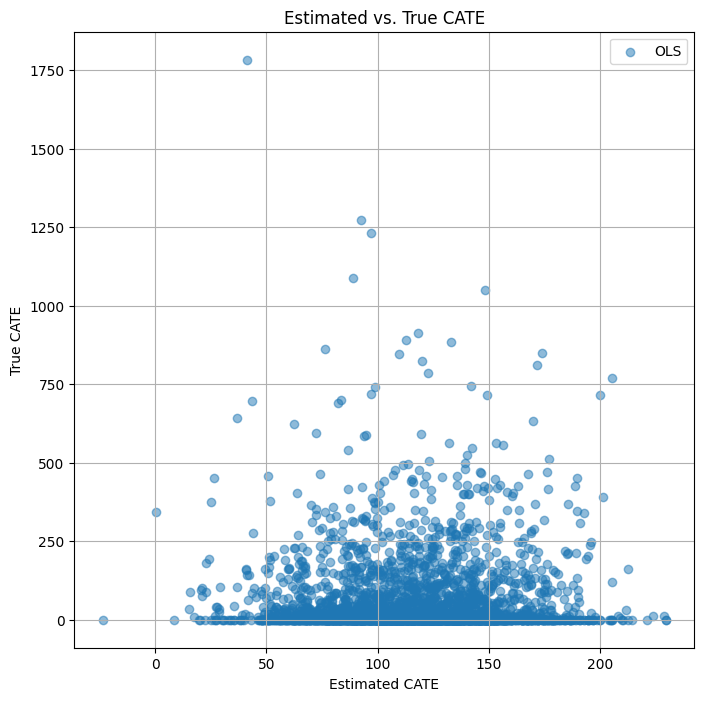

In [17]:
plt.figure(figsize=(8, 8))
plt.scatter(estimated_cate_ols, true_cate_test, alpha=0.5, label='OLS')
plt.plot()
plt.xlabel('Estimated CATE')
plt.ylabel('True CATE')
plt.title('Estimated vs. True CATE')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
estimated_cate_ols=estimated_cate_ols.reshape(-1, 1)
true_cate_test=true_cate_test.reshape(-1,1)
reg = LinearRegression().fit(estimated_cate_ols, true_cate_test)
reg.score(estimated_cate_ols, true_cate_test)

0.0003229897014542793

Causal Forest DML

In [19]:
#define model_t to reflect known treatment probabilities
model_t = DummyClassifier()

#Estimate the causal forest model
est = CausalForestDML(model_y='auto',
                      model_t=model_t,
                      discrete_treatment=True,
                      cv=5,
                      n_estimators=1000,
                      random_state=42,
                      criterion='mse',
                      honest=True)

est.fit(Y_train, T_train, X=X_train, W=None, cache_values=True)


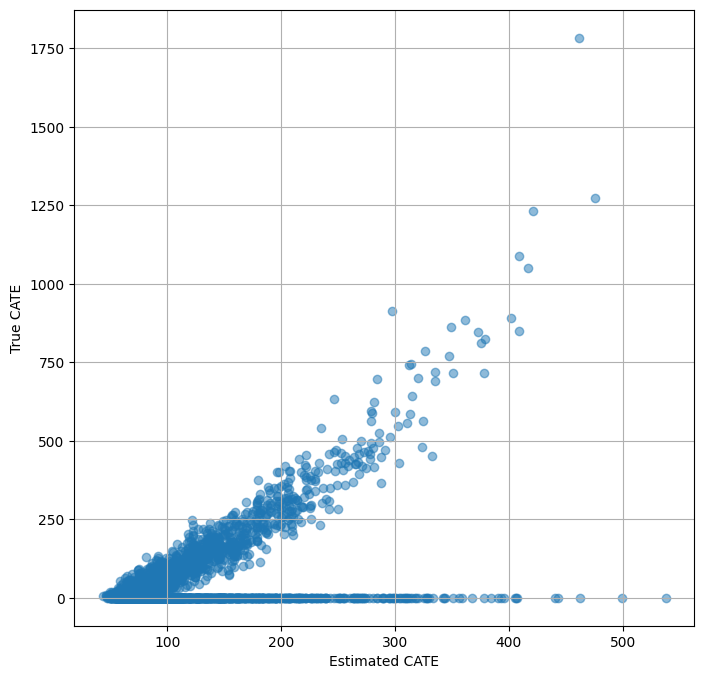

In [20]:
estimated_cate = est.effect(X_test)

plt.figure(figsize=(8, 8))
plt.scatter(estimated_cate, true_cate_test, alpha=0.5)
plt.plot()
plt.xlabel('Estimated CATE')
plt.ylabel('True CATE')
plt.grid(True)
plt.show()

In [22]:
estimated_cate=estimated_cate.reshape(-1, 1)
reg = LinearRegression().fit(estimated_cate, true_cate_test)
reg.score(estimated_cate, true_cate_test)

0.3449451868219261